In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import root_pandas

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def fig_ax(figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    return fig, ax

In [3]:
# fname = 'root://eoslhcb.cern.ch//eos/lhcb/user/a/apearce/CharmProduction/2015_MagDown_MC/27163003/1/DVntuple.root'
fname = 'DVntuple.root'
key = 'TupleD0ToKpi'
mc = root_pandas.read_root(fname, key='MC' + key + '/MCDecayTree',
                           columns=['D0_TRUEPT', 'D0_TRUEP_E', 'D0_TRUEP_Z', 'runNumber', 'eventNumber'],
                           where='totCandidates == 1')
reco = root_pandas.read_root(fname, key='Cheated' + key + '/DecayTree',
                             columns=['D0_PT', 'D0_PE', 'D0_PZ', 'runNumber', 'eventNumber'],
                             where='totCandidates == 1 && D0_BKGCAT < 20')

In [4]:
# Add rapidity
mc = mc.assign(D0_TRUE_Y=0.5*np.log((mc.D0_TRUEP_E + mc.D0_TRUEP_Z)/(mc.D0_TRUEP_E - mc.D0_TRUEP_Z)))
reco = reco.assign(D0_Y=0.5*np.log((reco.D0_PE + reco.D0_PZ)/(reco.D0_PE - reco.D0_PZ)))

del mc['D0_TRUEP_E']
del mc['D0_TRUEP_Z']
del reco['D0_PE']
del reco['D0_PZ']

In [5]:
len(mc), len(reco)

(2422527, 989084)

In [6]:
merged = pd.merge(mc, reco, how='inner', on=['runNumber', 'eventNumber'])
print(len(merged))

943181


In [7]:
merged.head()

,D0_TRUEPT,runNumber,eventNumber,D0_TRUE_Y,D0_PT,D0_Y
0,2910.313524,5794071,377462,1.891396,2898.258647,1.891226
1,1208.604055,5794071,377463,3.056536,1209.831645,3.059436
2,1329.563323,5794071,377466,2.503029,1334.055030,2.505954
3,635.060046,5794071,377467,2.930167,639.728771,2.932593
4,514.141355,5794071,377469,3.002605,508.575321,3.006468


(-50, 50)

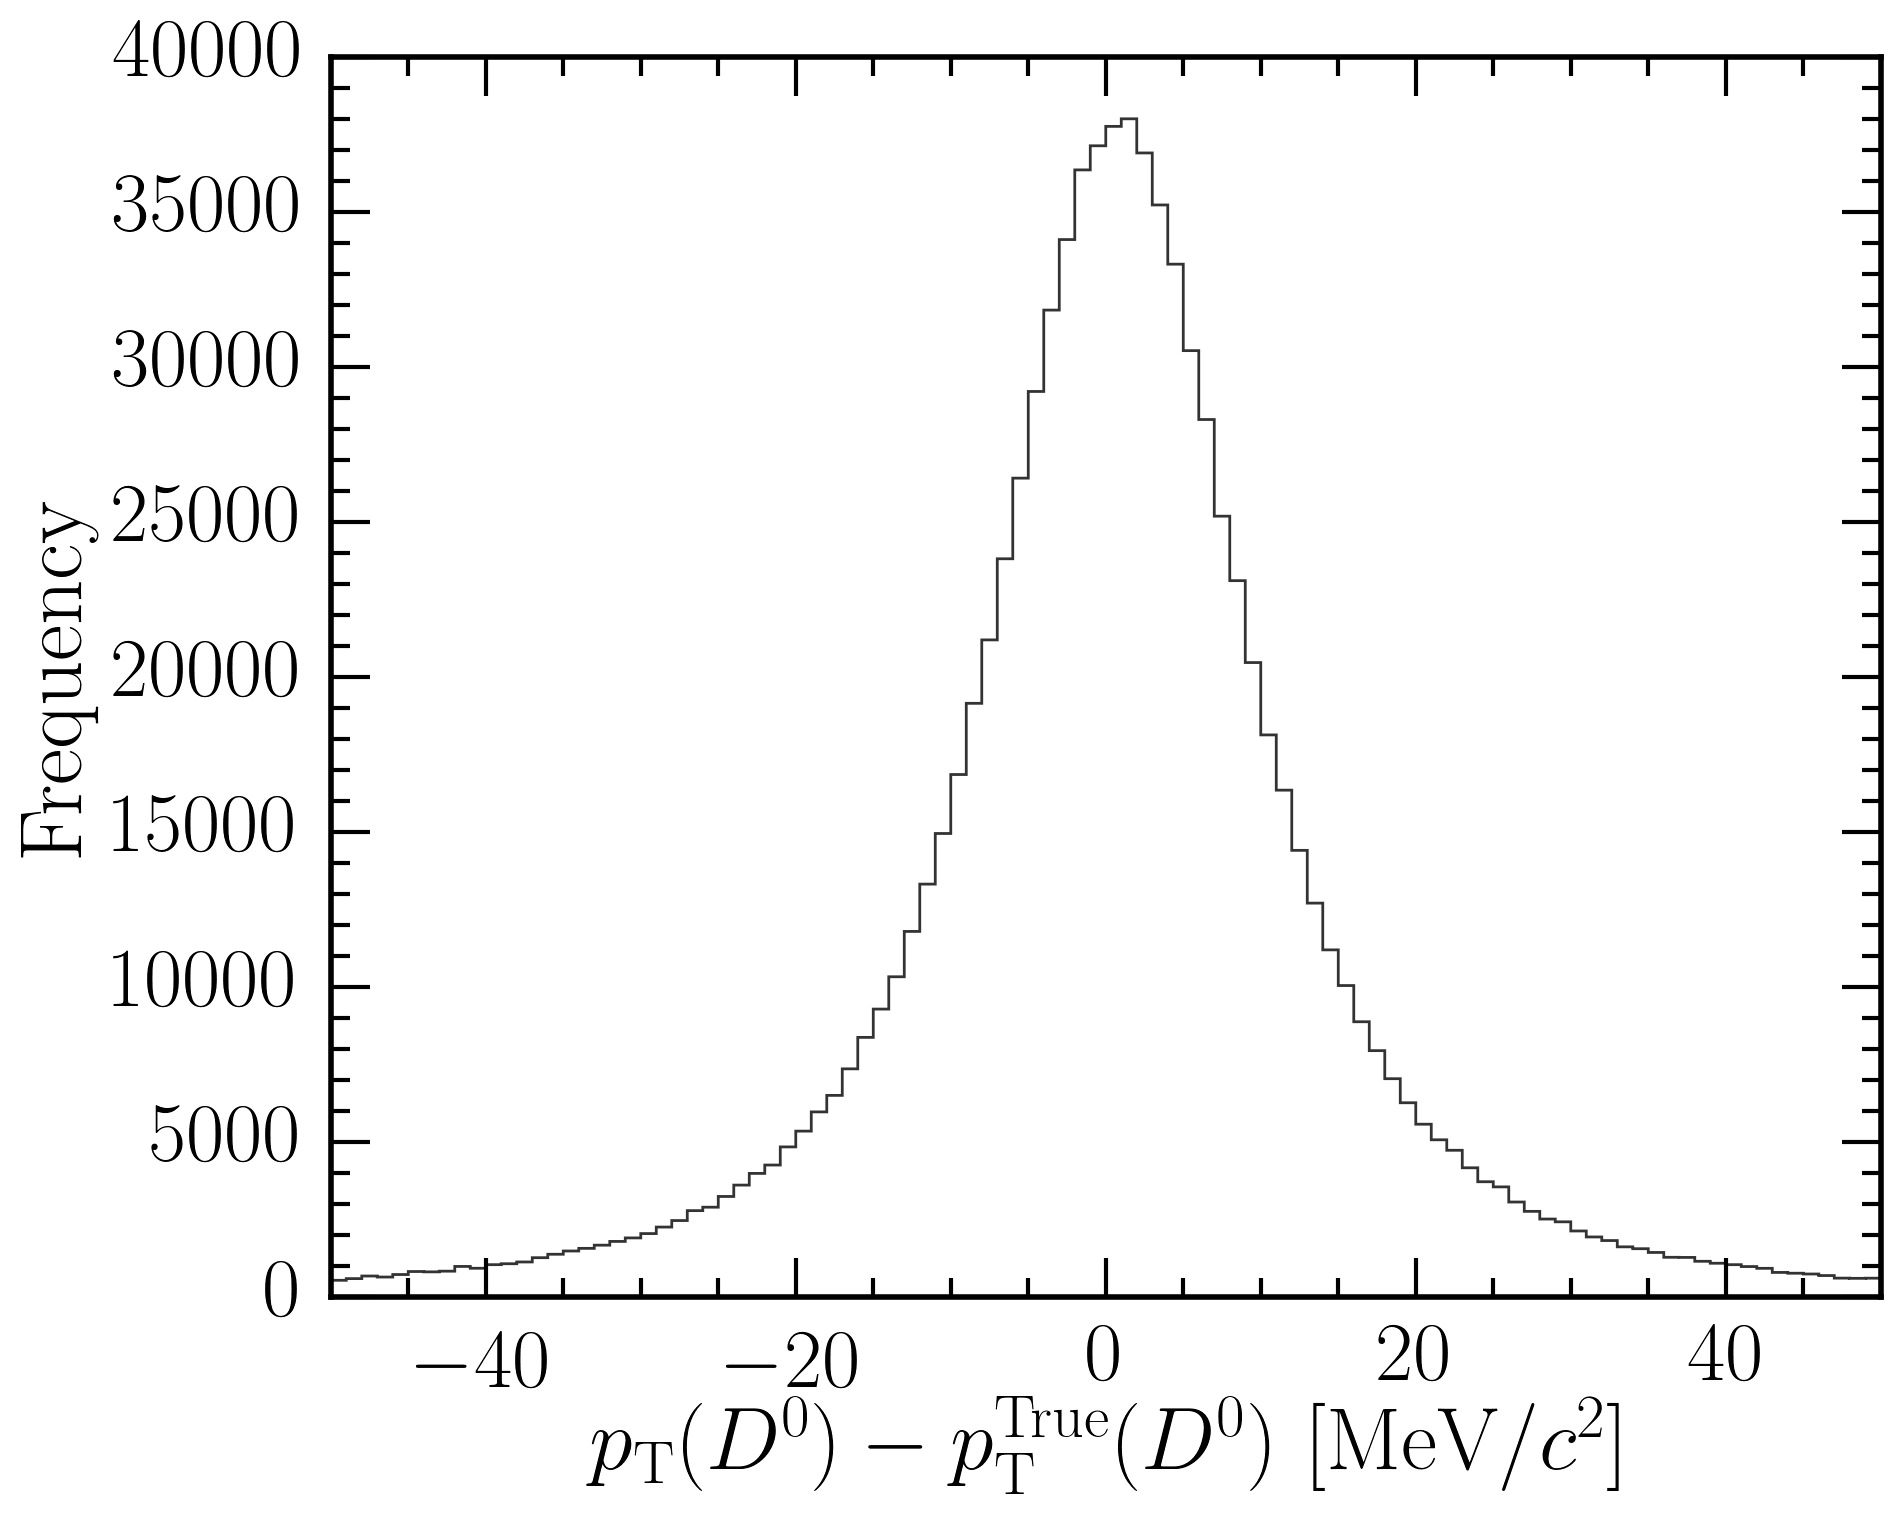

In [8]:
difference = (merged.D0_PT - merged.D0_TRUEPT)
difference_range = (-50, 50)
difference_label = r'$p_{\mathrm{T}}(D^{0}) - p_{\mathrm{T}}^{\mathrm{True}}(D^{0})$ [MeV/$c^{2}$]'

fig, ax = fig_ax()
difference.plot.hist(bins=100, range=difference_range, histtype='step')
ax.set_xlabel(difference_label)
ax.set_xlim(difference_range)

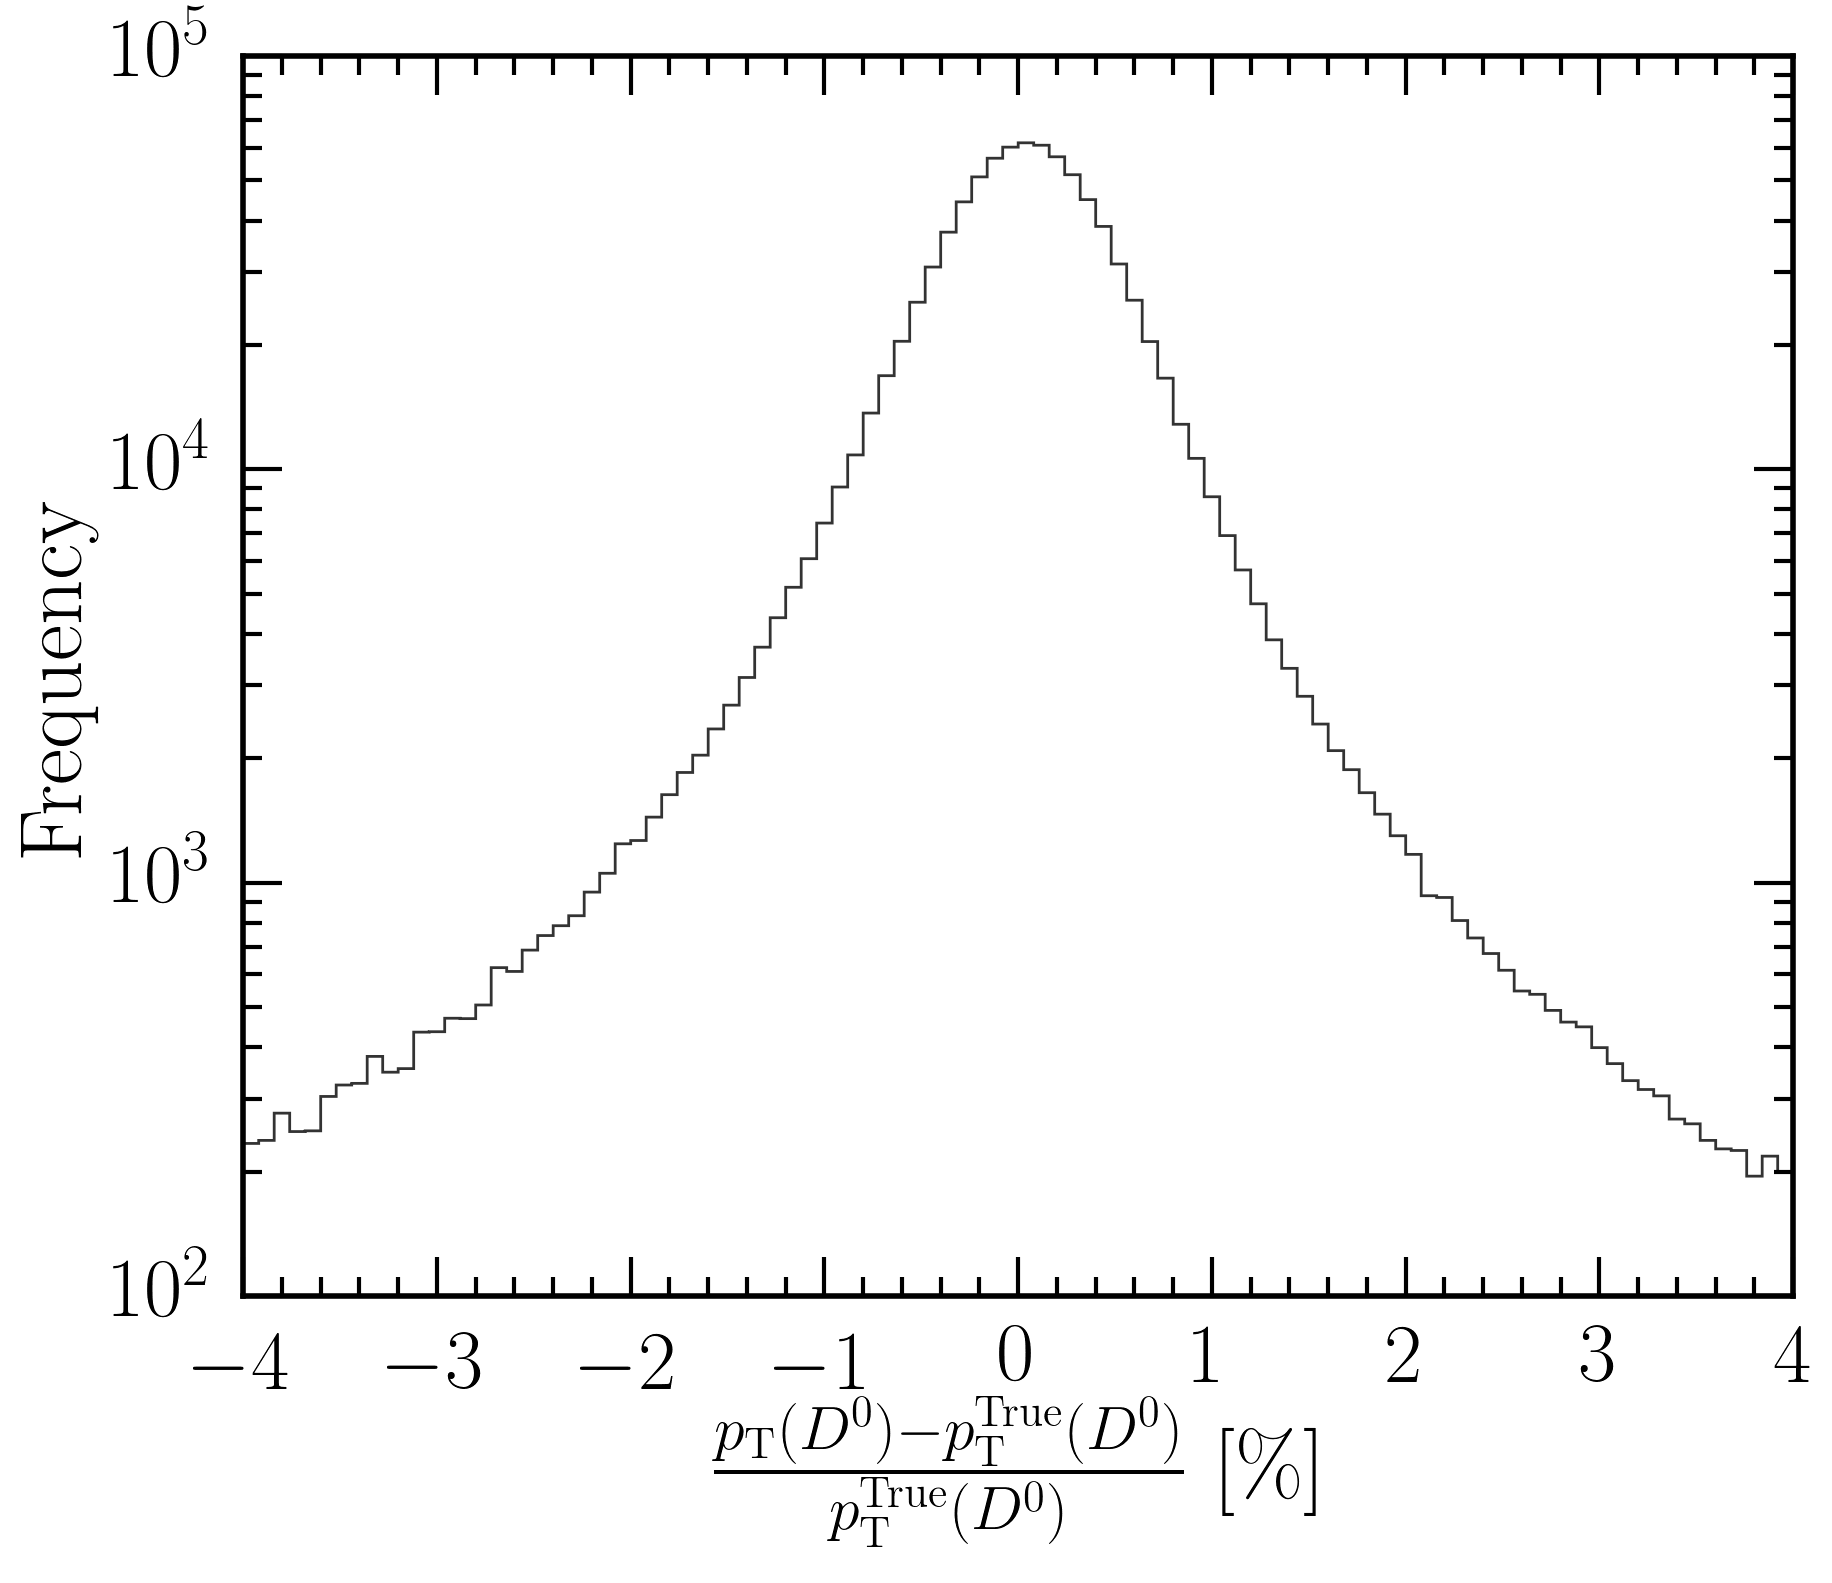

In [9]:
difference_normalised = 100*difference/merged.D0_TRUEPT
difference_normalised_range = (-4, 4)
difference_normalised_label = r'$\frac{p_{\mathrm{T}}(D^{0}) - p_{\mathrm{T}}^{\mathrm{True}}(D^{0})}{p_{\mathrm{T}}^{\mathrm{True}}(D^{0})}$ [$\%$]'

fig, ax = fig_ax()
difference_normalised.plot.hist(bins=100, range=difference_normalised_range, histtype='step')
ax.set_xlim(difference_normalised_range)
ax.set_xlabel(difference_normalised_label)
ax.set_yscale('log')

In [10]:
edges = 1e3*np.concatenate([np.arange(0, 1, 1), np.arange(1, 3, 0.5), np.arange(3, 16, 1)])
print(edges)

[     0.   1000.   1500.   2000.   2500.   3000.   4000.   5000.   6000.
   7000.   8000.   9000.  10000.  11000.  12000.  13000.  14000.  15000.]


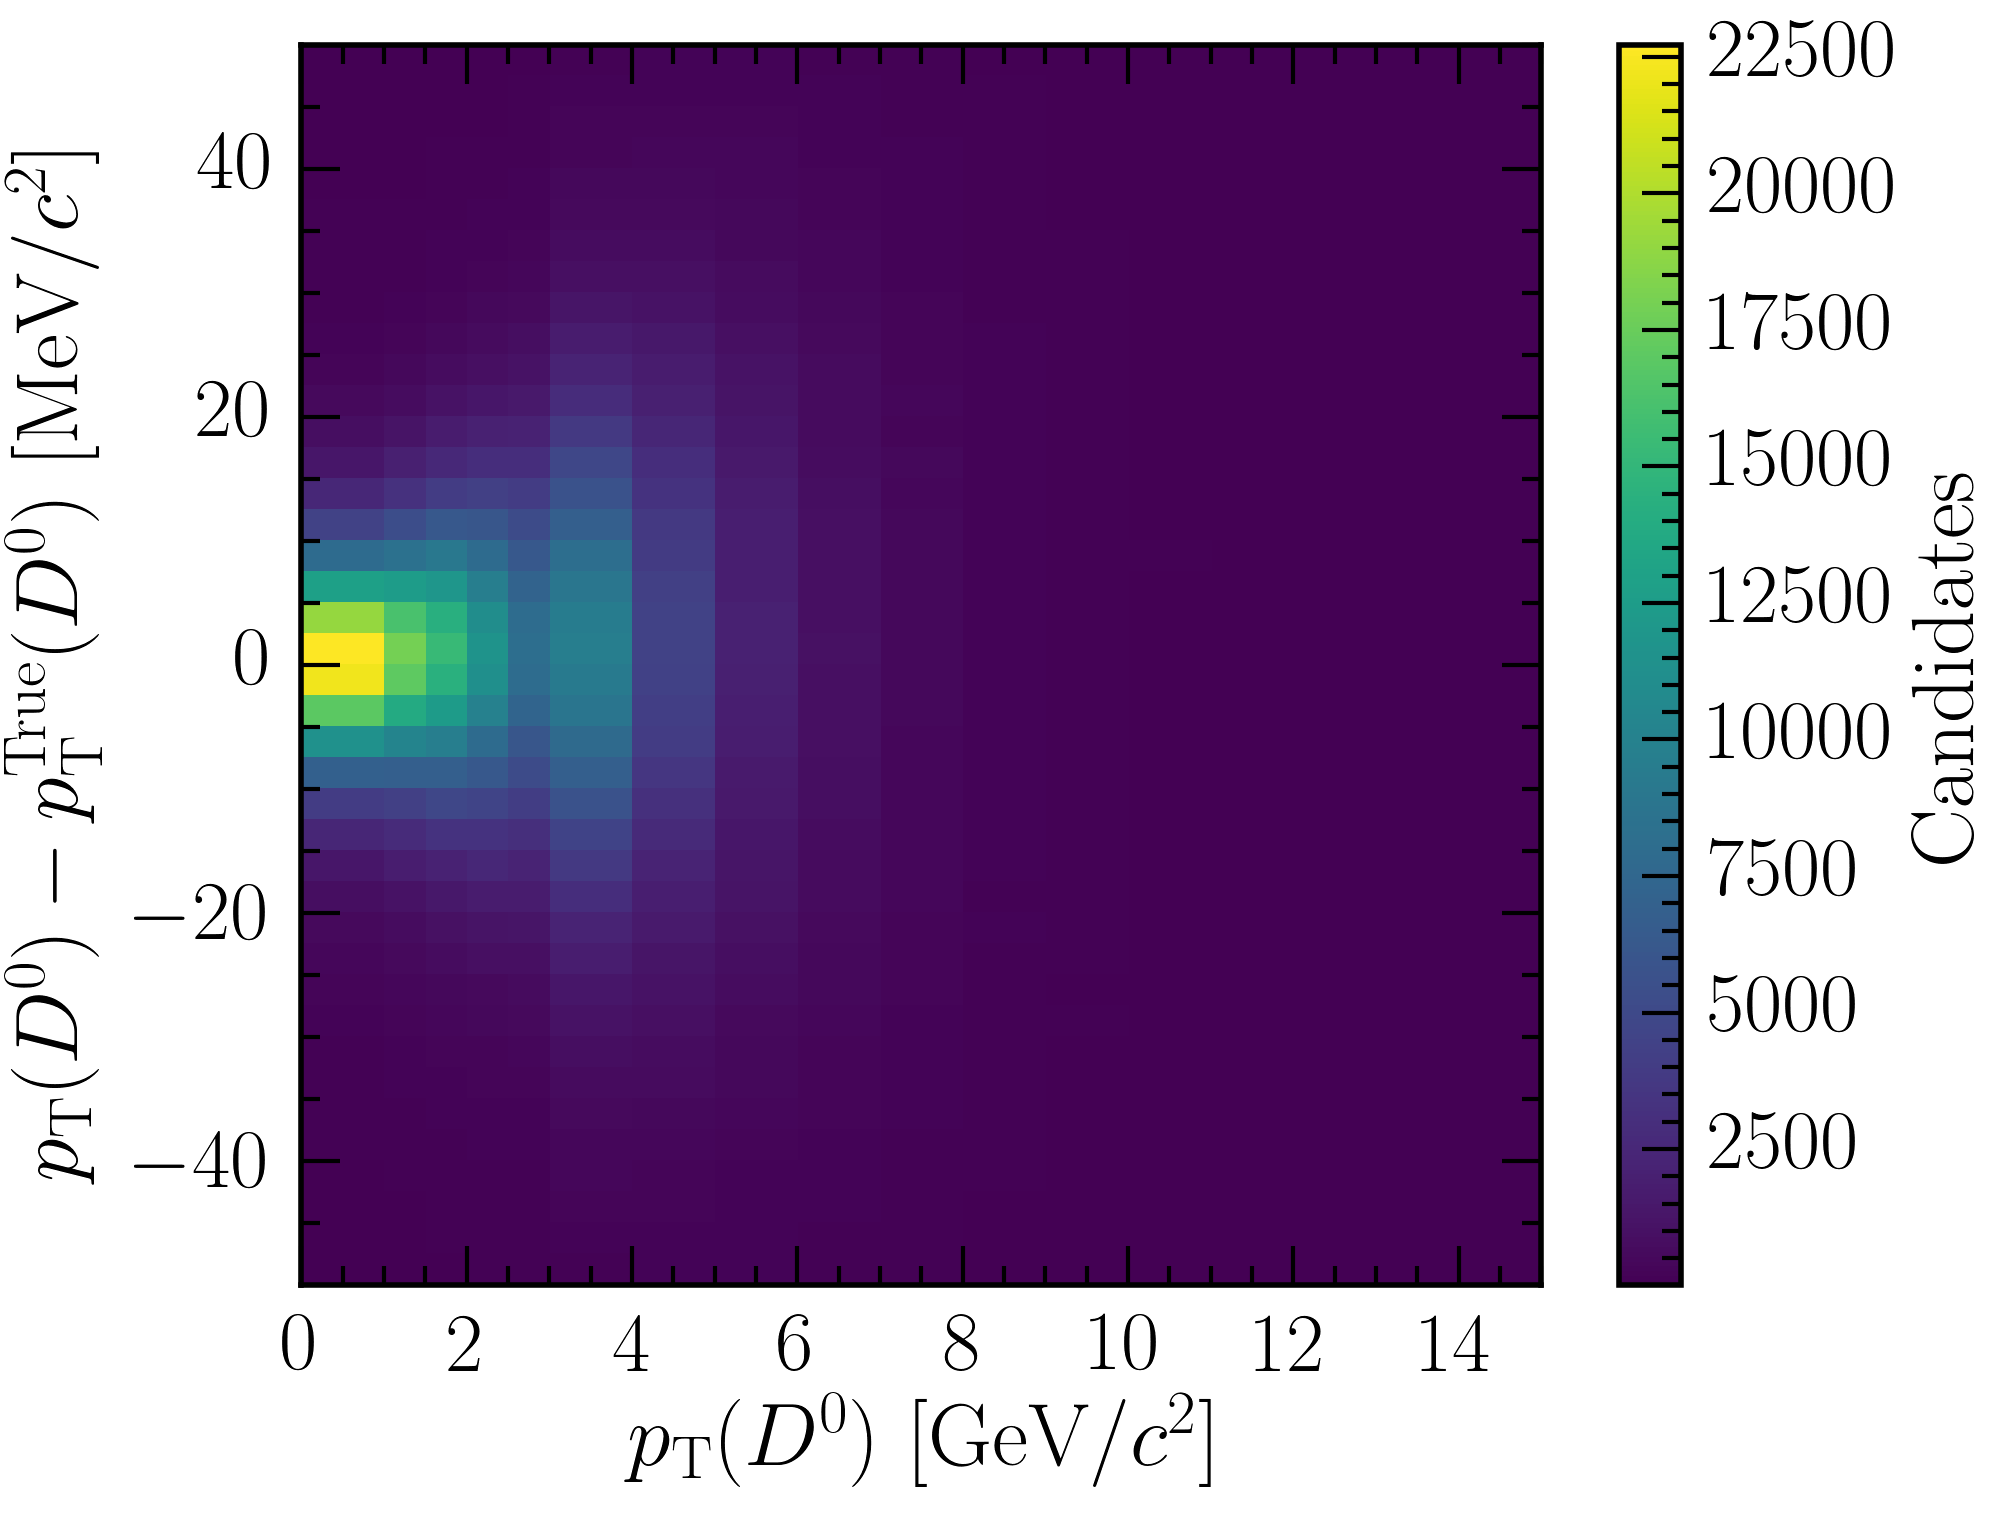

In [11]:
fig, ax = fig_ax()
H, xedges, yedges, C = ax.hist2d(
    merged.D0_PT/1e3, difference,
    bins=(edges/1e3, 40),
    range=((edges[0]/1e3, edges[-1]/1e3), difference_range),
    cmap='viridis'
)
ax.set_xlabel('$p_{\mathrm{T}}(D^{0})$ [GeV/$c^{2}$]')
ax.set_ylabel(difference_label)
cb = fig.colorbar(C, ax=ax)
cb.set_label('Candidates')

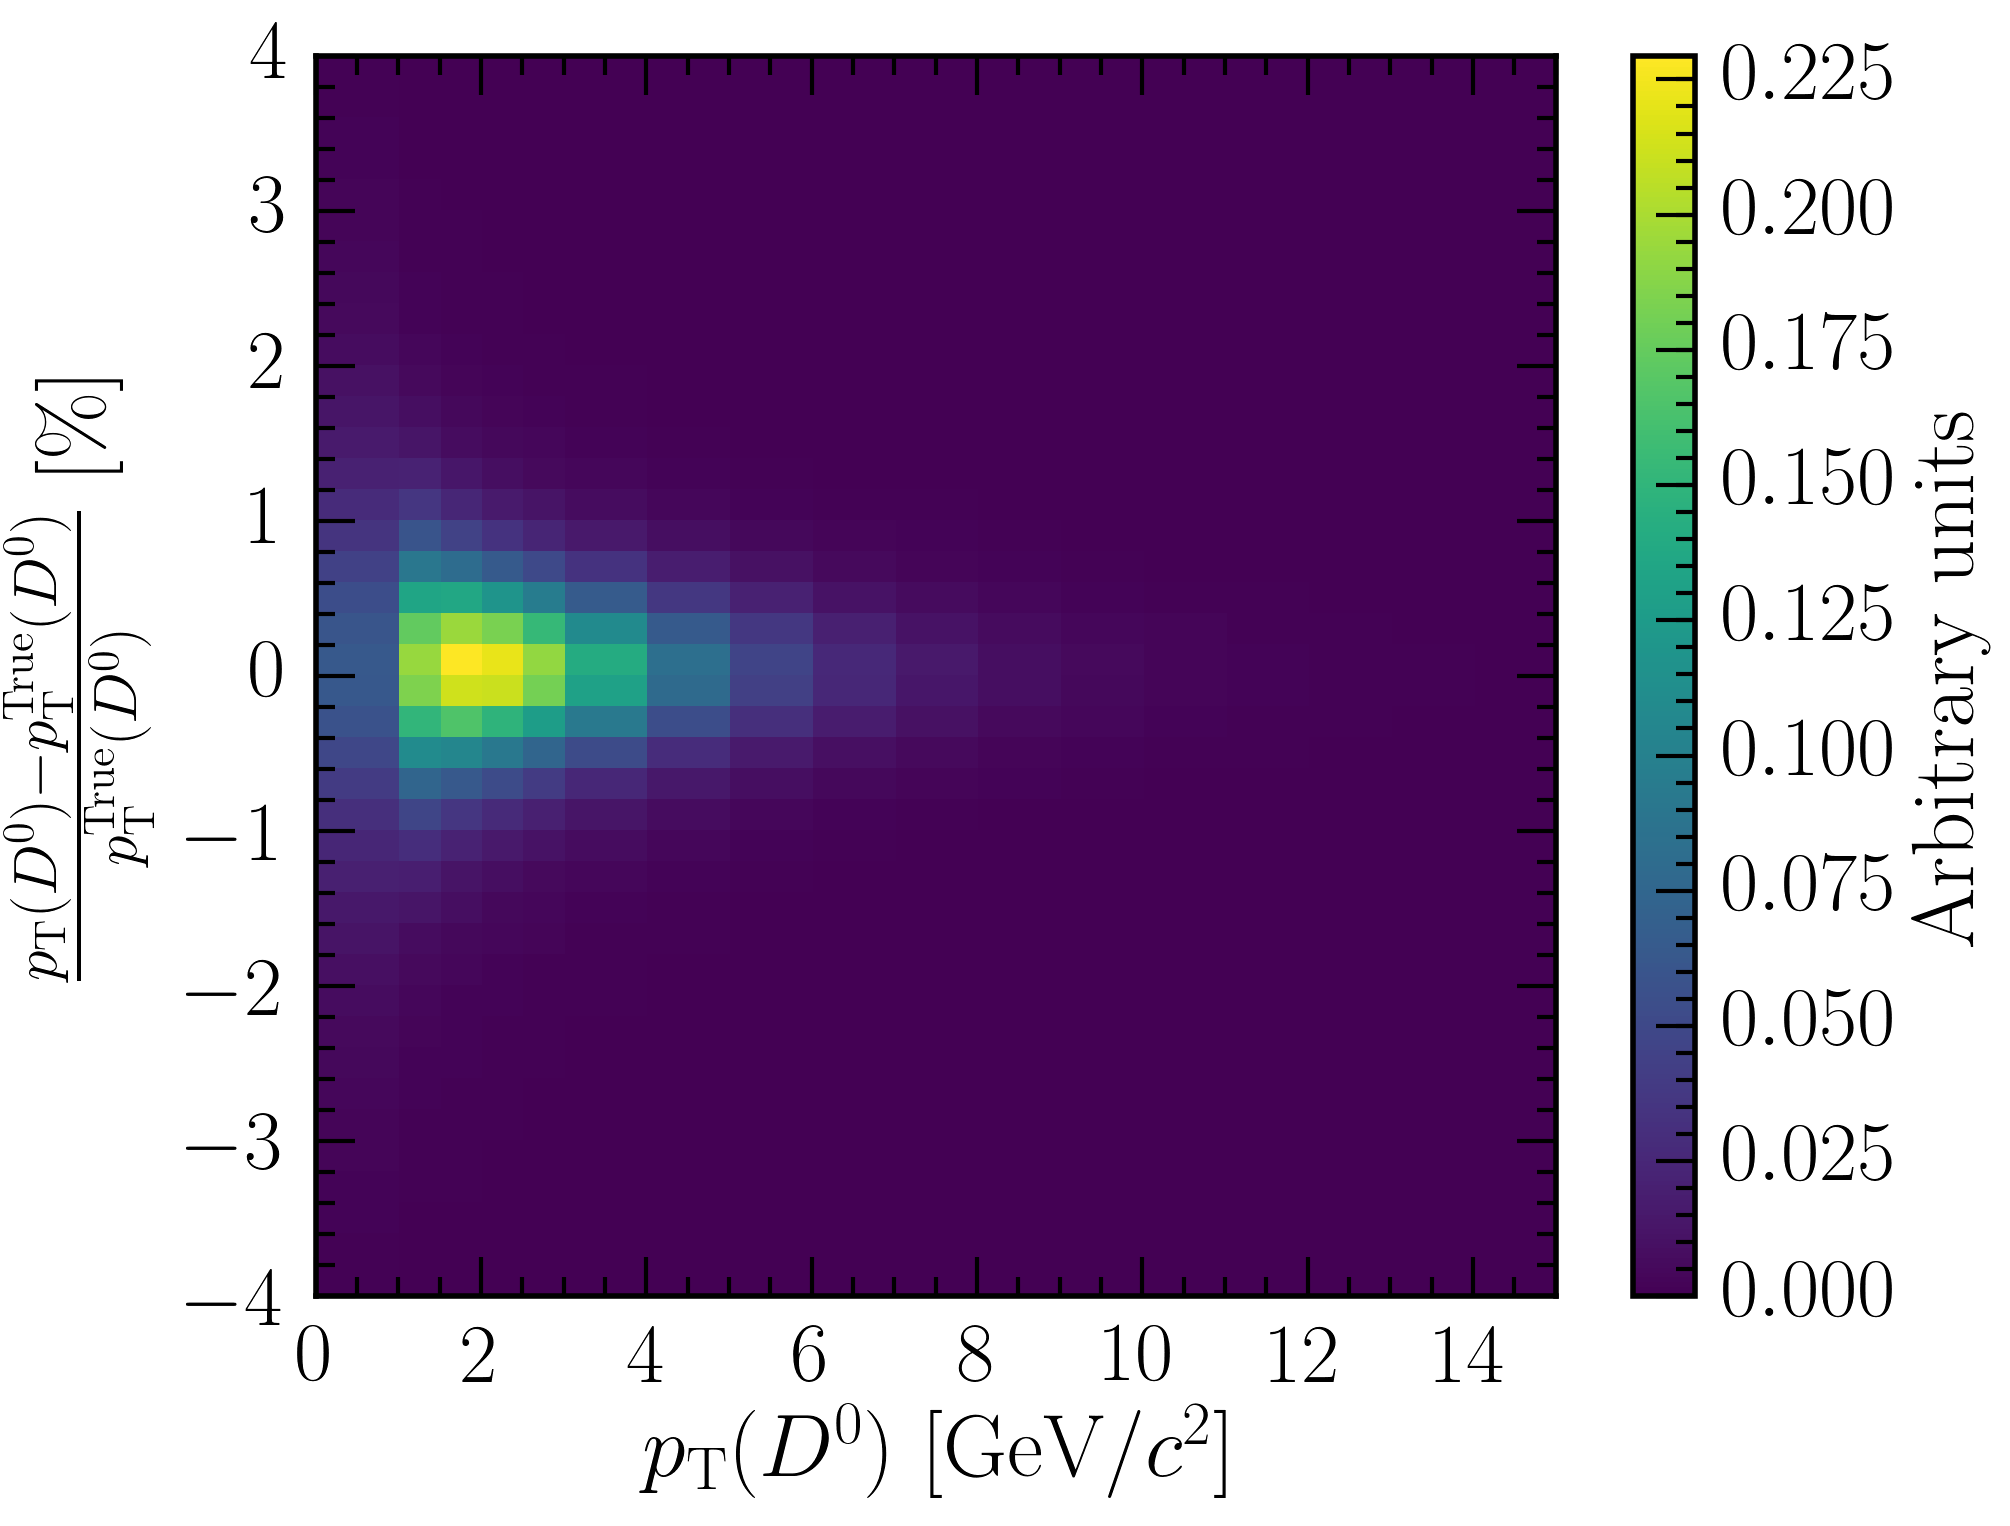

In [12]:
fig, ax = fig_ax()
H, xedges, yedges, C = ax.hist2d(
    merged.D0_PT/1e3, difference_normalised,
    bins=(edges/1e3, 40),
    normed=True,
    range=((edges[0]/1e3, edges[-1]/1e3), difference_normalised_range),
    cmap='viridis'
)
ax.set_xlabel('$p_{\mathrm{T}}(D^{0})$ [GeV/$c^{2}$]')
ax.set_ylabel(difference_normalised_label)
cb = fig.colorbar(C, ax=ax)
cb.set_label('Arbitrary units')
fig.savefig('output/D0ToKpi_PT_resolution.pdf')

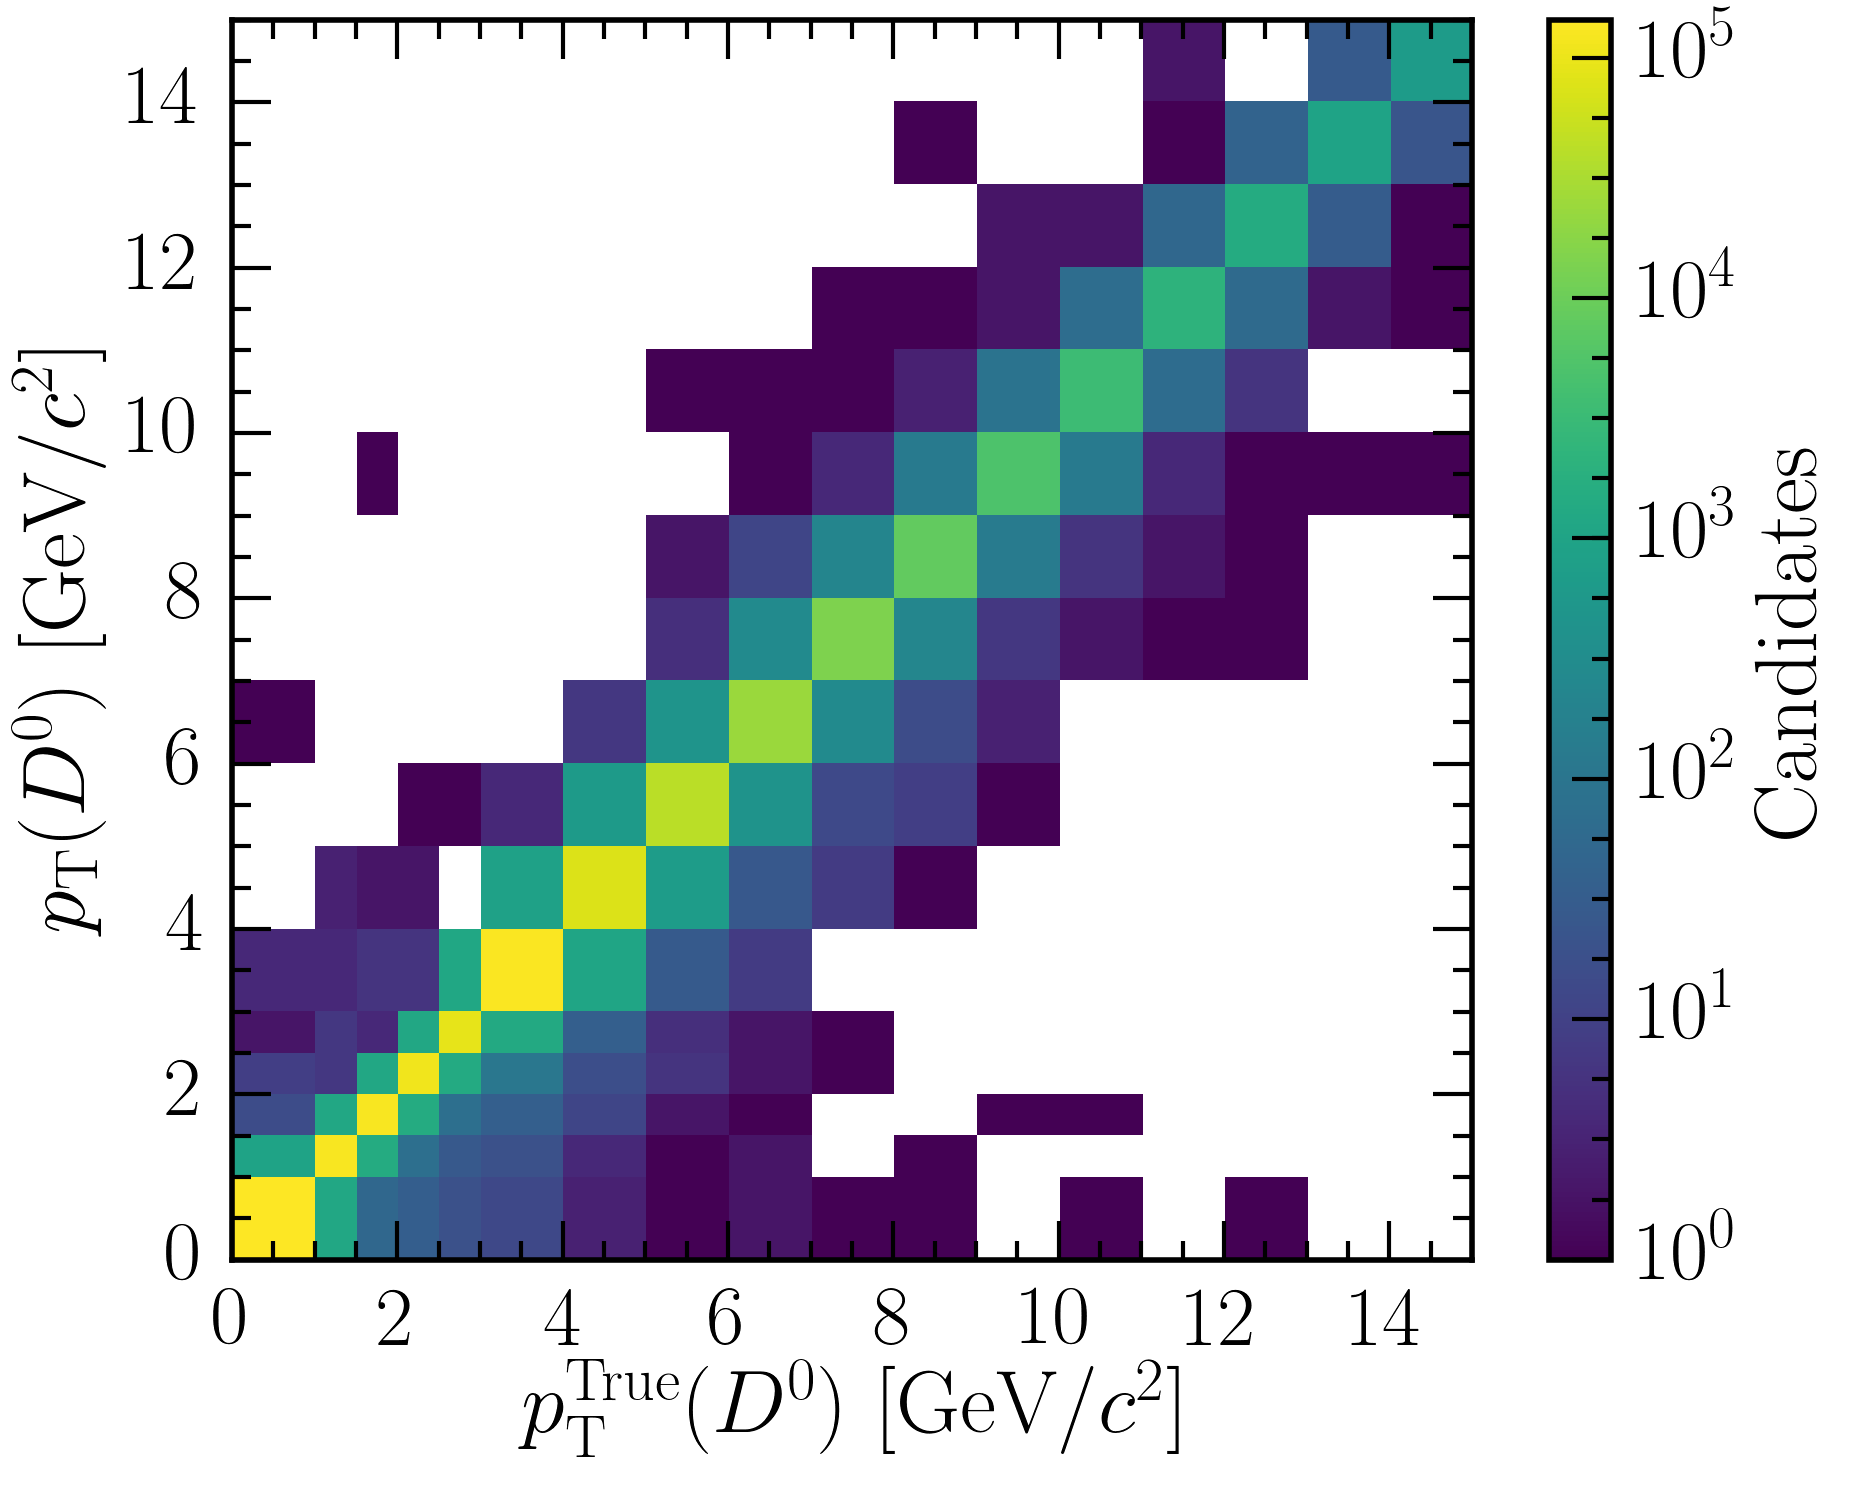

In [13]:
fig, ax = fig_ax()
H, xedges, yedges, C = plt.hist2d(
    merged.D0_TRUEPT/1e3, merged.D0_PT/1e3,
    bins=(edges/1e3, edges/1e3),
    range=((edges[0]/1e3, edges[-1]/1e3), (edges[0]/1e3, edges[-1]/1e3)),
    norm=matplotlib.colors.LogNorm(),
    cmap='viridis'
)
ax.set_xlabel('$p_{\mathrm{T}}^{\mathrm{True}}(D^{0})$ [GeV/$c^{2}$]')
ax.set_ylabel('$p_{\mathrm{T}}(D^{0})$ [GeV/$c^{2}$]')
cb = fig.colorbar(C, ax=ax)
cb.set_label('Candidates')

In [14]:
gev = 1e-3
H, xedges, yedges = np.histogram2d(
    merged.D0_TRUEPT*gev, merged.D0_PT*gev,
    bins=(edges*gev, edges*gev)
)
H /= H.diagonal()

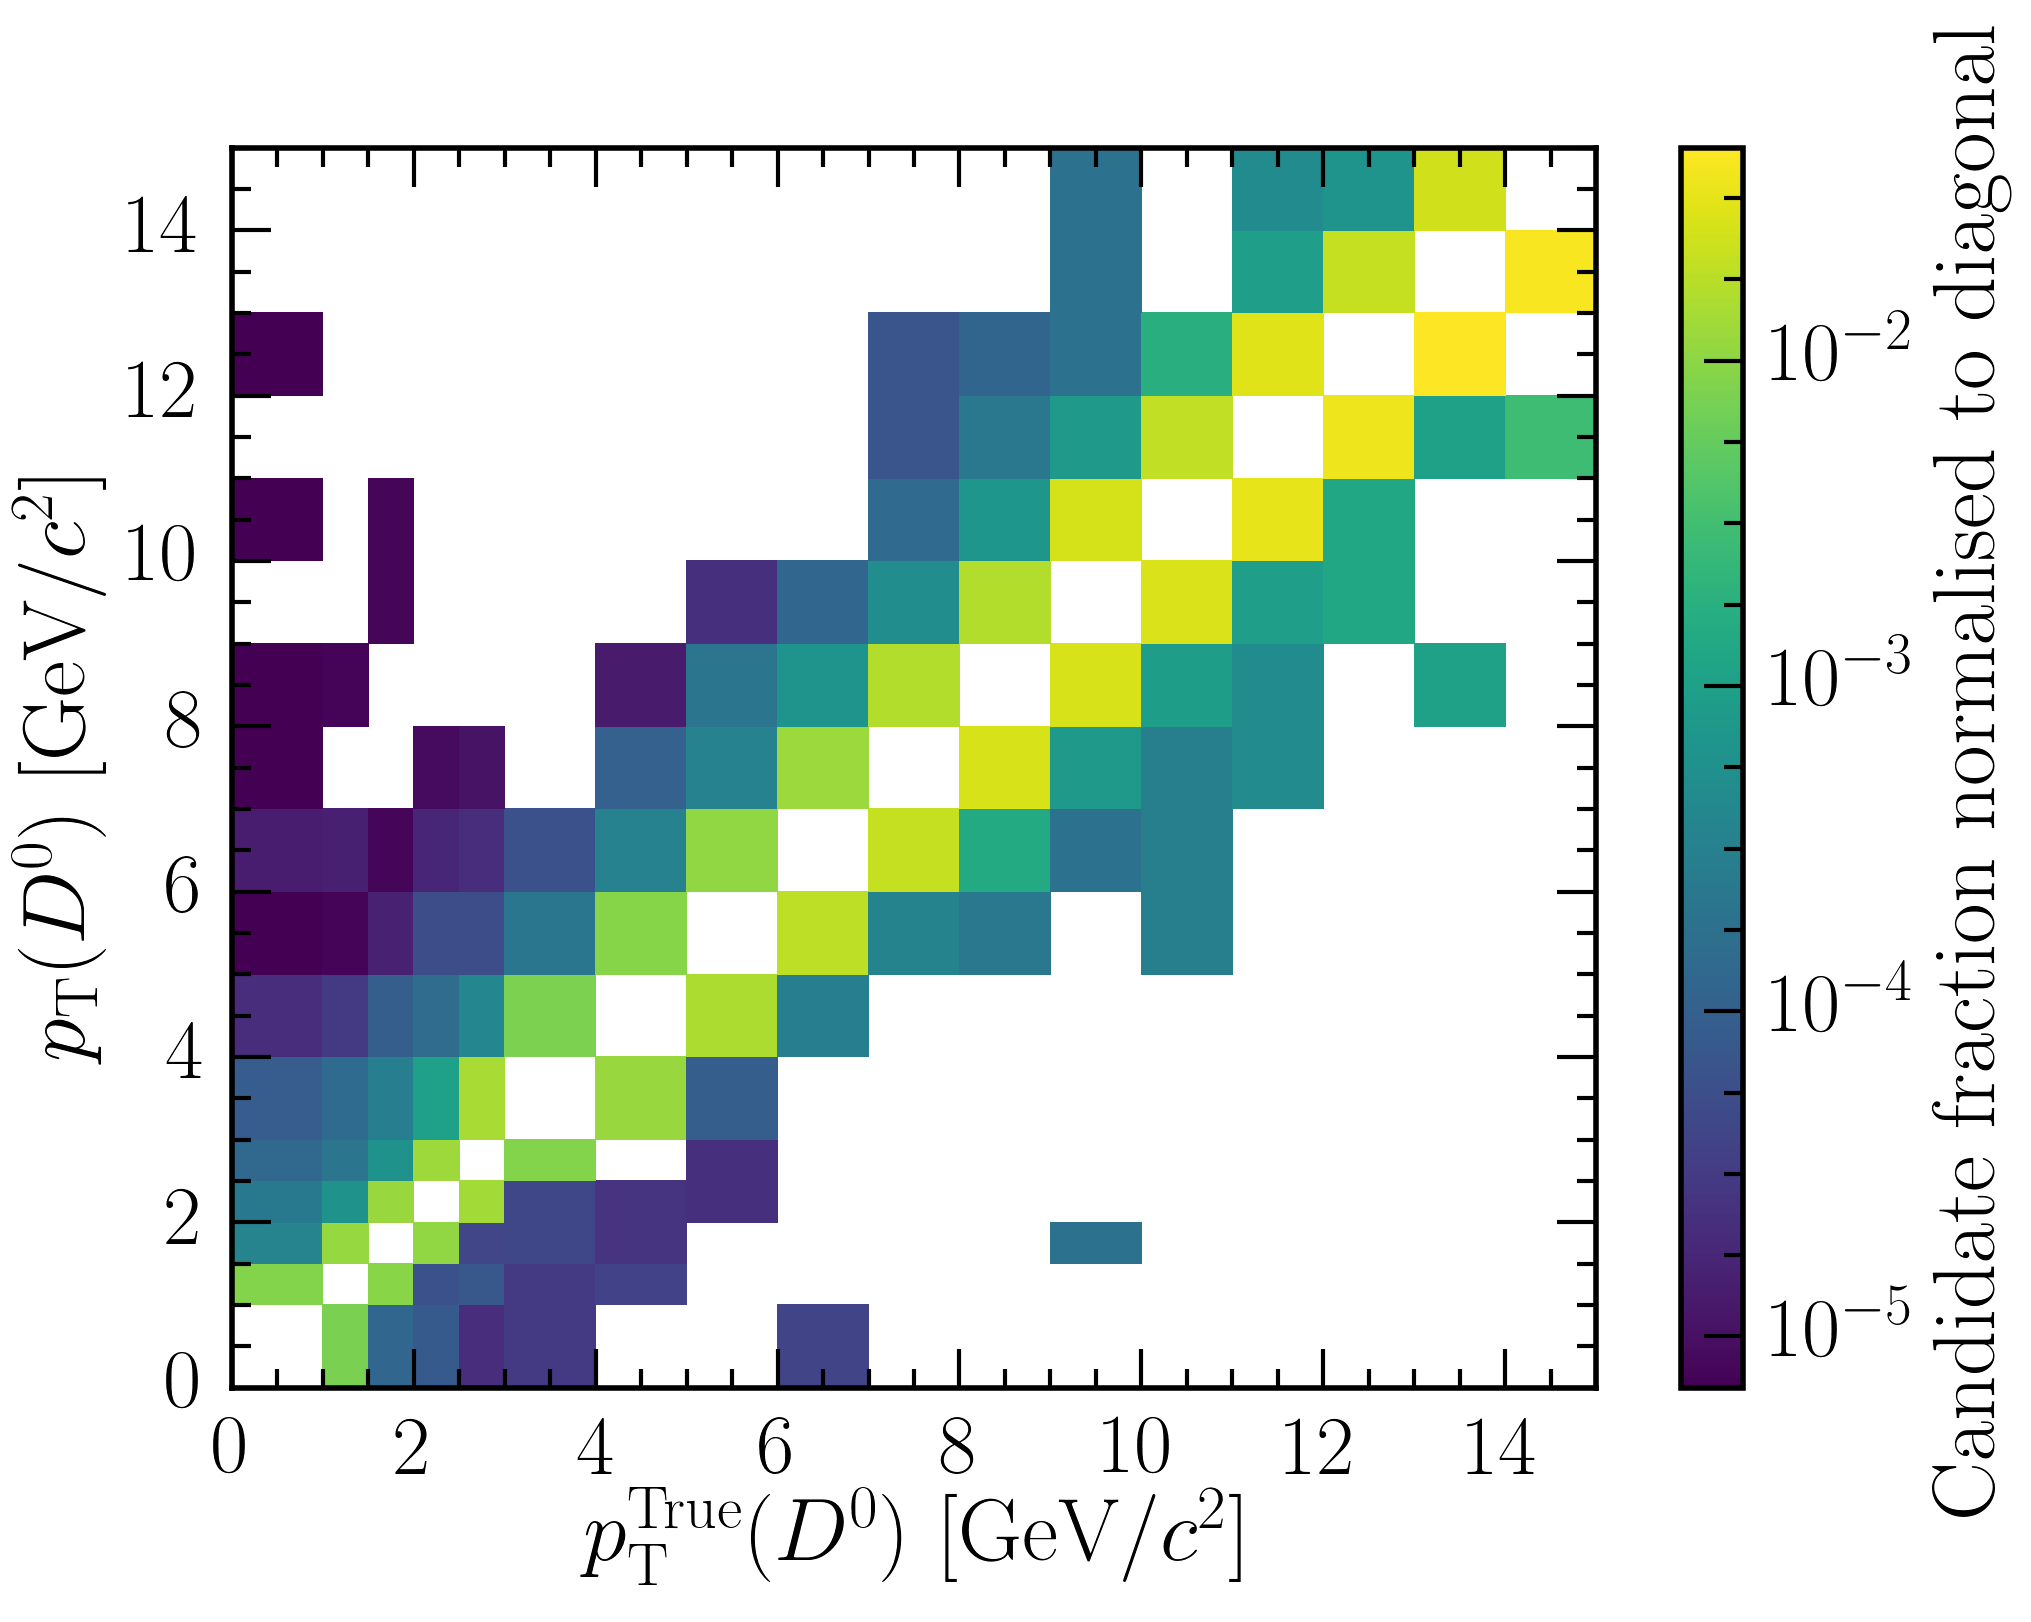

In [15]:
# Mask the diagonal elements
H[H == 1] = 0
fig, ax = fig_ax((11, 8))
C = ax.pcolormesh(
    xedges, yedges, H,
    norm=matplotlib.colors.LogNorm(),
    cmap='viridis'
)
ax.set_xlim((xedges[0], xedges[-1]))
ax.set_ylim((yedges[0], yedges[-1]))
ax.set_xlabel('$p_{\mathrm{T}}^{\mathrm{True}}(D^{0})$ [GeV/$c^{2}$]')
ax.set_ylabel('$p_{\mathrm{T}}(D^{0})$ [GeV/$c^{2}$]')
cb = fig.colorbar(C, ax=ax)
cb.set_label('Candidate fraction normalised to diagonal')
fig.savefig('output/D0ToKpi_PT_migration_matrix.pdf')

In [16]:
edges_rapidity = np.arange(2, 5, 0.5)
print(edges_rapidity)

[ 2.   2.5  3.   3.5  4.   4.5]


In [17]:
difference_rapidity = (merged.D0_Y - merged.D0_TRUE_Y)
difference_rapidity_normalised = 100*difference_rapidity/merged.D0_TRUE_Y
difference_rapidity_normalised_range = (-0.4, 0.4)
difference_rapidity_normalised_label = r'$\frac{y(D^{0}) - y^{\mathrm{True}}(D^{0})}{y^{\mathrm{True}}(D^{0})}$ [$\%$]'

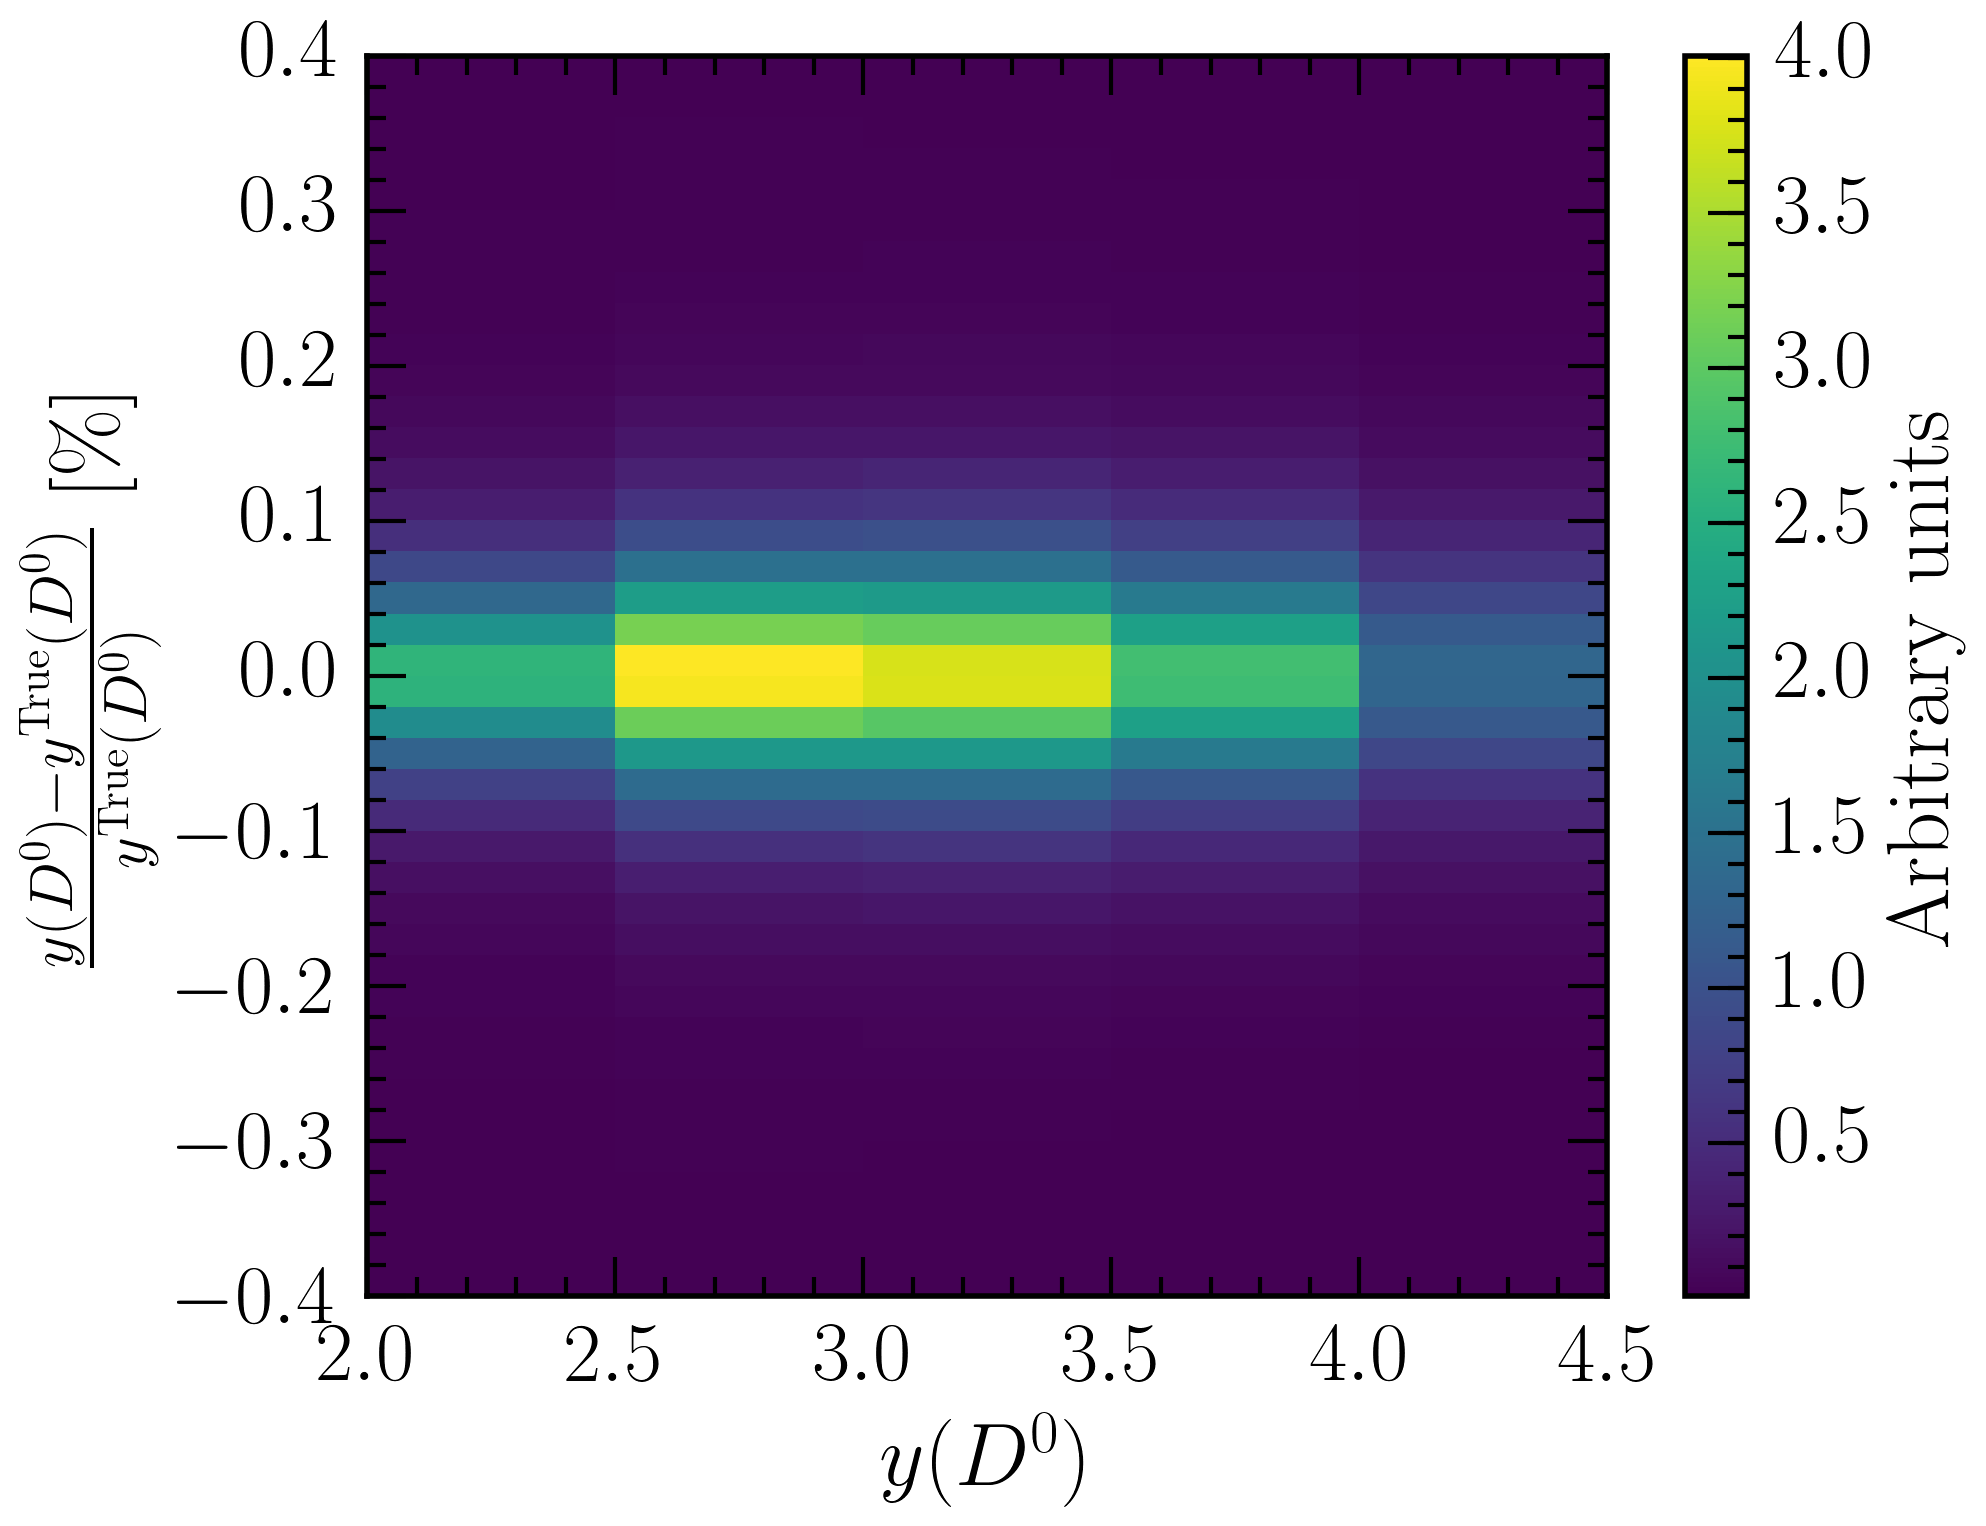

In [18]:
fig, ax = fig_ax()
H, xedges, yedges, C = ax.hist2d(
    merged.D0_Y, difference_rapidity_normalised,
    bins=(edges_rapidity, 40),
    normed=True,
    range=((edges_rapidity[0], edges_rapidity[-1]), difference_rapidity_normalised_range),
    cmap='viridis'
)
ax.set_xlabel('$y(D^{0})$')
ax.set_ylabel(difference_rapidity_normalised_label)
cb = fig.colorbar(C, ax=ax)
cb.set_label('Arbitrary units')
fig.savefig('output/D0ToKpi_y_resolution.pdf')

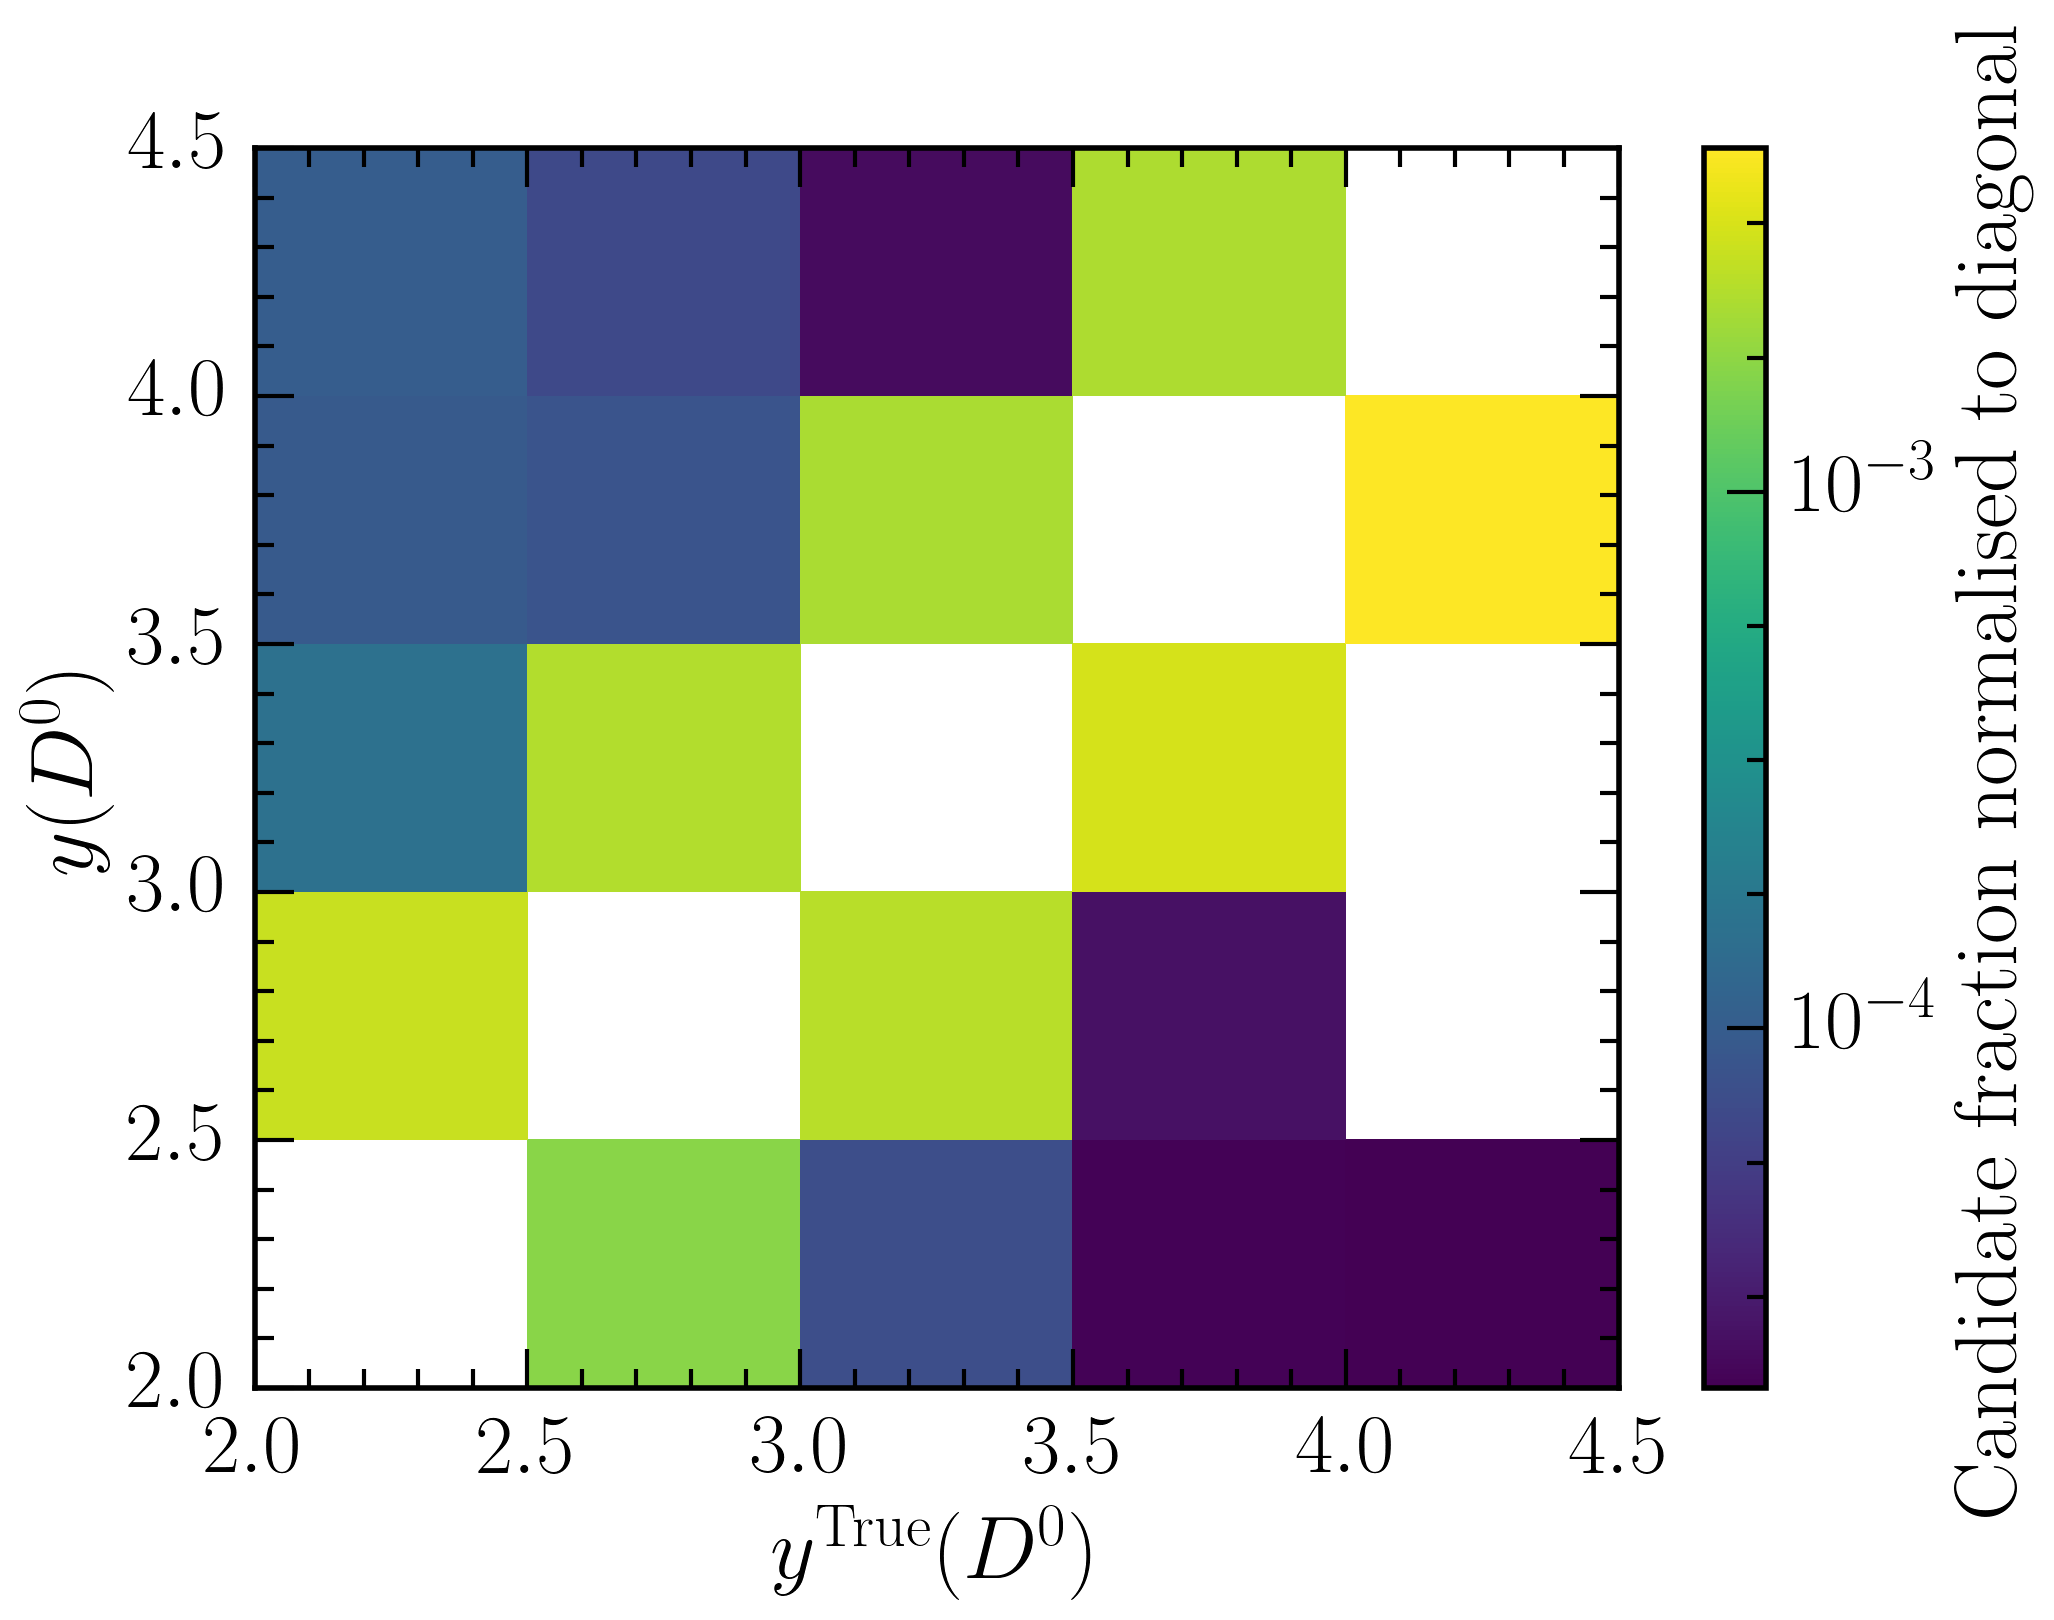

In [19]:
H, xedges, yedges = np.histogram2d(
    merged.D0_TRUE_Y, merged.D0_Y,
    bins=(edges_rapidity, edges_rapidity)
)
H /= H.diagonal()
# Mask the diagonal elements
H[H == 1] = 0
fig, ax = fig_ax((11, 8))
C = ax.pcolormesh(
    xedges, yedges, H,
    norm=matplotlib.colors.LogNorm(),
    cmap='viridis'
)
ax.set_xlim((xedges[0], xedges[-1]))
ax.set_ylim((yedges[0], yedges[-1]))
ax.set_xlabel('$y^{\mathrm{True}}(D^{0})$')
ax.set_ylabel('$y(D^{0})$')
cb = fig.colorbar(C, ax=ax)
cb.set_label('Candidate fraction normalised to diagonal')
fig.savefig('output/D0ToKpi_y_migration_matrix.pdf')